# Interprétabilité des modèles
## 0. Overview

La montée en complexité des modèles de Machine learning et Deep learning introduit bien souvent des modèles avec d'importantes quantités de paramètres, rendant leurs intérprétations complexes.

Pourtant, il est très important d'être capable de comprendre les décisions prises par un modèle. Cela permet avant tout de les optimiser, mais aussi de les rendre plus accessibles pour des pôles plus orientés métiers.

=> **L'objectif de ce notebook est la mise en pratique de l'interprétabilité des modèles sur des cas concrets**

### 0.1 Données

Pour la suite de ce notebook, nous nous baserons sur 2 jeux de données connus :
* **boston** : ce dataset vise à déterminer le prix de vente des maisons de Boston en fonction de différents indicateurs
* **iris** : ce dataset vise à classifier des iris suivant 3 catégories en fonction de différentes informations sur les fleurs

Nous commencerons par utiliser le jeu de données **boston**. Son importation est disponible ci-dessous. Vous retrouverez aussi le dictionnaire des variables présentes.

In [1]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=["Houses prices"])
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

## 1. Focus sur les Forêts Aléatoires en Régression

### 1.1 Import des packages

In [2]:
import warnings # On enlève les warnings pour la suite du notebook
warnings.filterwarnings('ignore')

In [3]:
from treeinterpreter import treeinterpreter as ti, utils
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.grid_search import GridSearchCV

### 1.2 Idée générale

Beaucoup d'ouvrages traitant des **Forêts Aléatoires** considèrent ces modèles comme *black-blox*. En cause : le grand nombre d'arbres profonds, où chaque arbre est entrainé sur un échantillon bootstrap, et ou chaque noeud de l'arbre est partitionné sur la base d'un sous échantillon de variables tiré aléatoirement.

Il est donc compliqué d'avoir une compréhension complète du processus de décision. Une solution généralement apportée est de calculer l'importance des variables du modèle. L'idée est de permuter les valeurs de chaque variable une à une, et de déterminer quelle permutation à le plus d'impact sur la performance du modèle.


L'approche sur laquelle nous allons nous baser est différente, et s'appuie sur les **chemins de décisions** formés par les arbres. Lorsque l'on s'intéresse à un arbre de décision, il est assez intuitif qu'il existe, pour chaque décision, un chemin partant du noeud racine jusqu'à un noeud terminal. Ce chemin est constitué d'une série de décisions basées sur une ou plusieurs variables, qui contribuent donc à la prédiction.

#### 1.2.1 L'approche des chemins de décision

Un arbre de décision avec $M$ noeuds divise l'espace des données en $M$ régions, notées $R_m, 1≤m≤M$. De manière générale, si l'on définit $x$ une nouvelle observation et $f$ la fonction de prédiction de l'arbre, on a :

<center> $ f(x) = \sum\limits_{m=1}^{M}c_m \mathbb{1}_{(x\ \in \ R_m)} $ </center> 

Avec :
* $c_m$ la valeur de sortie pour la région $R_m$. $c_m$ est déterminée lors de la phase d'apprentissage de l'arbre
* $\mathbb{1}_{(x\ \in \ R_m)}$ la fonction indicatrice renvoyant 1 si $x\ \in \ R_m$, 0 sinon

##### 1.2.1.1 L'exemple d'un arbre de régression

Partons maintenant d'un exemple pour comprendre l'approche des chemins de décision. Nous nous baserons sur le jeu de données **boston**. Pour rappel, on cherche à déterminer le prix des maisons de Boston en fonction de différents indicateurs.


<img src="Tree2.png" alt="Drawing" style="width: 400px;" align="left"/>
L'image à gauche montre un arbre de régression de pronfondeur 3. On retrouve un champ *Value* en dessous de chaque noeud. Ce dernier représente la moyenne des prix des maisons, et est logiquement différent suivant l'emplacement ou l'on se situe dans l'arbre.

Cela permet de suivre l'évolution des prix des maisons suivant les coupures réalisées par différentes variables.

Le but principal de cet exemple est de faire apparaître qu'il existe un moyen "opérationnel" de décomposer les prédictions au travers des **chemins de décision**.

La *Value* du noeud racine (i.e. *22.60* ici) correspond à la moyenne des prix des maisons sur les données d'apprentissage, nous l'appellerons **priormean** par la suite. Ainsi, chaque prédiction partant du noeud racine, peut être définie comme le **priormean** auquel on soustrait ou ajoute les contributions des variables sur le chemin de décision.


Par exemple, pour une nouvelle observation $x$ dont la variable $RM$ est inférieure à *6.94*, on se retrouve à descendre la première branche verte de l'arbre. A ce niveau, les observations de l'échantillon d'apprentissage ont une moyenne des prix des maisons de *37.42*. Le priormean étant de *22.60*, on peut considérer que la contribution de la variable $RM$ à été de faire augmenter la prédiction de *14.82* (*37.42-22.60*).

L'opération est donc à répeter au fur et à mesure de la descente de l'arbre jusqu'au noeud terminal.

La fonction de prédiction peut donc se réécrire :

<center> $ f(x) = c_{full} + \sum\limits_{k=1}^{K}contrib(x,k) $ </center> 

Avec :
* $K$ le nombre de variables
* $cfull$ la valeur du noeud racine (*Value* sur l'arbre ci-dessus)
* $contrib(x, k)$ la contribution de la $k$-ième variable à la prédiction de $x$. 


On retrouve quelque chose qui, en apparence, ressemble à une régression linéaire du type $f(x) = ax + b$.
Toutefois, en régression linéaire, le vecteur de paramètres $a$ est constant. Dans le cas de l'arbre de décision, les contributions des variables varient suivant le chemin de décision impliqué.

Cela permet cependant de décomposer une prédiction et donc de pouvoir plus facilement l'interpréter.

#### 1.2.1.2 Le passage aux Forêts Aléatoires

L'application de ce principe d'un arbre de décision à une Forêt Aléatoire est relativement simple. En effet, la prédiction d'une forêt est la moyenne des prédictions de ses arbres. Soit $g$ la fonction de prédiction d'une forêt, et $x$ une nouvelle observation. On a :

<center> $ g(x) = \frac{1}{J} \sum\limits_{j=1}^{J}f_j(x) $ </center> 

Avec :
* $J$ le nombre d'arbres de la forêt
* $f_j(x)$ la préction pour la nouvelle observation $x$ pour l'arbre $j$


On peut donc facilement écrire :

<center> $ g(x) = \frac{1}{J} \sum\limits_{j=1}^{J}c_{j_{full}} + \sum\limits_{k=1}^{K}(\frac{1}{J}\sum\limits_{j=1}^{J}contrib_j(x,k)) $ </center> 

#### 1.2.2 Première décomposition - Simplification du problème

Nous allons maintenant chercher à appliquer la décomposition vue précédemment.

Dans un premier temps, nous essaierons de décomposer le prix estimé d'une maison $i$ (notre variable cible) comme la somme des contributions de chaque variable pour cette maison, i.e. : 
<center> $ prediction^i=priormean+contributionVariable_1^i+…+contributionVariable_n^i $ </center> 

Peu de packages proposent actuellement de rentrer dans ce niveau de détails à l'heure actuelle. Nous nous baserons sur **treeinterpreter**. Ce dernier propose la décomposition exposée au dessus pour différents modèles existants sous *scikit-learn*, tels que :
* DecisionTreeRegressor
* DecisionTreeClassifier
* ExtraTreeRegressor
* ExtraTreeClassifier
* RandomForestRegressor
* RandomForestClassifier
* ExtraTreesRegressor
* ExtraTreesClassifier


#### 1.2.3 Première Forêt Aléatoire
**Exercice 1 :**
Pour commencer, séparez les données à disposition en 2 échantillons (via la fonction *train_test_split*) en définissant une graîne aléatoire (=1234) :
* un échantillon d'apprentissage (2/3 des données)
* un échantillon de validation (1/3 des données)

Entraînez ensuite une forêt (les paramètres par défaut suffiront pour l'exemple) sur la base de vos données d'apprentissage, en indiquant une graine aléatoire (=1234) pour figer les résultats.

*NB : Nous noterons X_train, X_test, y_train, y_test nos échantillons d'apprentissage et de validation, et rf le modèle entraîné*

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1/3, random_state=1234)

rf = RandomForestRegressor(random_state=1234)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

Nous allons maintenant choisir 2 points de données de notre échantillon de test, sur lequel nous allons prédire notre cible.

In [5]:
tworows = X_test.iloc[:2,]
for i,prediction in enumerate(rf.predict(tworows)):
    print("Prédiction pour ligne {} de notre échantillon de test : {}".format(i,round(prediction,2)))

Prédiction pour ligne 0 de notre échantillon de test : 32.18
Prédiction pour ligne 1 de notre échantillon de test : 23.78


On constate que les prédictions sont très éloignées pour ces 2 points de données. L'idée est donc de comprendre maintenant quelles sont les variables qui ont le plus contribuées (aussi bien négativement que positivement) aux prédictions.

Pour cela, nous allons réaliser la décomposition vue précédemment en utilisant le package **treeinterpreter**.

La structure est relativement simple, et nous permet, sur la base d'un modèle déjà entraîné, de récupérer pour des points de données de l'échantillon de test, la prédiction du modèle, le priormean, ainsi que les contributions de chaque variable :

In [6]:
prediction, priormean, contributions = ti.predict(rf, tworows)

Si l'on commence par s'intéresser au contenu de *prediction*, on remarque bien que l'on récupère les mêmes valeurs que ci-dessus. 

In [7]:
prediction

array([[32.18],
       [23.78]])

Le contenu de la variable *priormean*, qui pour rappel correspond à la moyenne de notre variable cible sur l'échantillon d'apprentissage, est logiquement le même qu'importe le point de données de test.

In [8]:
priormean

array([22.424273, 22.424273])

Enfin, la variable *contributions* contient deux arrays de dimensions *1x13* chacun, représentant pour chaque prédiction, la contribution de chacune des variables.

In [9]:
contributions

array([[ 6.60555556e-01,  0.00000000e+00,  7.50000000e-02,
         0.00000000e+00,  2.46911765e-01,  6.68611695e+00,
         4.71296296e-03, -9.32726952e-01,  4.50000000e-02,
         1.76981430e+00,  1.61194290e-01, -2.28973138e-01,
         1.26812127e+00],
       [-2.89914054e-01, -8.12566845e-02, -7.07142857e-02,
         0.00000000e+00,  1.82911765e-01,  1.84975041e-01,
        -2.87870370e-02,  7.94091021e-02,  2.83180189e-01,
        -3.20409387e-02, -1.88606092e+00, -6.34404762e-02,
         3.07746530e+00]])

On a donc tout ce qui est nécessaire pour déterminer les contributions de chacune des variables aux deux prédictions, en rappelant que :
<center> $ prediction=priormean+contributionVariable_1+…+contributionVariable_n $ </center> 

In [10]:
for i in range(len(tworows)):
    print("Point de données {}".format(i))
    print("Prior mean {}".format(priormean[i]))
    print("Contributions des variables (par décroissance absolue) :")
    for c, feature in sorted(zip(contributions[i], 
                                 boston.feature_names), 
                             key=lambda x: -abs(x[0])):
        print("{} : {}".format(feature, round(c, 2)))
    print("-"*20) 

Point de données 0
Prior mean 22.424272997032645
Contributions des variables (par décroissance absolue) :
RM : 6.69
TAX : 1.77
LSTAT : 1.27
DIS : -0.93
CRIM : 0.66
NOX : 0.25
B : -0.23
PTRATIO : 0.16
INDUS : 0.07
RAD : 0.05
AGE : 0.0
ZN : 0.0
CHAS : 0.0
--------------------
Point de données 1
Prior mean 22.424272997032645
Contributions des variables (par décroissance absolue) :
LSTAT : 3.08
PTRATIO : -1.89
CRIM : -0.29
RAD : 0.28
RM : 0.18
NOX : 0.18
ZN : -0.08
DIS : 0.08
INDUS : -0.07
B : -0.06
TAX : -0.03
AGE : -0.03
CHAS : 0.0
--------------------


**Exercice 2** : A partir des informations récupérées (*priormean* et *contributions*) et sur la base de la décomposition exposée, recalculer les prédictions pour nos 2 points de données de test. Vérifiez qu'elles correspondent bien à ce que nous avions obtenu avec *scikit-learn*.

In [11]:
prediction,priormean + np.sum(contributions, axis=1)

(array([[32.18],
        [23.78]]), array([32.18, 23.78]))

Ce package est donc très pratique pour pouvoir mieux interpréter les prédictions de nos forêts aléatoires pour certains points de données.

Le package possède **2 intérêts majeurs** :
* Comprendre pourquoi les valeurs prédites sur 2 jeux de données sont différentes, et quelles sont les variables en causes. Sur le jeu de données *boston*, on pourrait par exemple chercher à comprendre d'où viennent les différences de prix des maisons de plusieurs voisinages
* Débugger un modèle et/ou les données, en cherchant par exemple à comprendre pourquoi les valeurs prédites sur un nouveau jeu de données ne matchent pas avec celles d'anciennes données

=> **Essayons de développer le premier cas**.

**Exercice 3** : Splitter le jeu de données de test *(X_test)* en 2 sous échantillons (respectivement *ech1* & *ech2*) de tailles égales. Ces échantillons modéliseront 2 voisinages. En utilisant la forêt déjà entraînée, calculez et stockez les prédictions associées à ces 2 sous échantillons. Calculez ensuite la moyenne des prédictions pour *ech1* et *ech2*.

In [12]:
idx = round(len(X_test)/2)
ech1 = X_test.iloc[:idx,:]
ech2 = X_test.iloc[idx:,:]

pred_ech1 = rf.predict(ech1)
pred_ech2 = rf.predict(ech2)
print(np.mean(pred_ech1),np.mean(pred_ech2))

22.977142857142855 21.662823529411764


On peut constater que les prédictions moyennes sont relativement différentes sur les 2 échantillons.

**Exerice 4** : Appliquer la décomposition vue précedemment sur les 2 sous échantillons *ech1* et *ech2*. On notera *prediction1, priormean1* et *contributions1* (respectivement *2*) les variables dans lequelles seront stockées les résultats.

Moyennez ensuite les contributions par variable pour chaque sous échantillon et stockez les résultats dans deux variables, respectivement *totalc1* et *totalc2*.

In [13]:
prediction1, priormean1, contributions1 = ti.predict(rf, ech1)
prediction2, priormean2, contributions2 = ti.predict(rf, ech2)

totalc1 = np.mean(contributions1, axis=0) 
totalc2 = np.mean(contributions2, axis=0) 

Dans la mesure où les *priormean* sont les mêmes (puisque calculés sur le même échantillon d'apprentissage), la différence entre les prédictions moyennes sur les 2 sous échantillons provient uniquement des contributions des différentes variables.
En outre, la différence entre les contributions des variables est égale à la différence entre les prédictions. Ce que nous pouvons facilement vérifier.


In [14]:
np.sum(totalc1 - totalc2),np.mean(prediction1) - np.mean(prediction2)

(1.3143193277310923, 1.3143193277310914)

**Exercice 5** : Calculer les différences de contributions de chaque variable entre les 2 sous échantillons, et appuyez vous sur le dictionnaire des données disponible en début de notebook pour interpréter.

In [15]:
for c, variable in sorted(zip(totalc1 - totalc2, 
                             boston.feature_names), reverse=True):
    print('{} : {}'.format(variable, round(c, 2)))

LSTAT : 0.45
RM : 0.43
DIS : 0.19
B : 0.13
AGE : 0.11
PTRATIO : 0.08
RAD : 0.05
TAX : 0.03
ZN : 0.03
CHAS : 0.0
INDUS : -0.02
CRIM : -0.07
NOX : -0.1


#### 1.2.4 Seconde décomposition

Rendre les prévisions de nos forêts aléatoires intérprétable semble donc assez simple, et relativement proche de ce que l'on connaît avec des modèles linéaires.

Cependant, **cette décomposition est imparfaite, puisqu'elle ne prend pas en compte les intéractions entre variables.**
Pour l'illustrer, prenons l'exemple du XOR (= ou exclusif).

##### 1.2.4.1 L'exemple du XOR

In [16]:
pd.DataFrame({'X1': [0, 0, 1, 1], 'X2': [0, 1, 0, 1], 'Sortie': [0, 1, 1, 0]})

,X1,X2,Sortie
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


Le **XOR** est relativement facile à comprendre. Pour que la valeur de sortie soit Vraie (=1), il faut que l'une seule des valeurs de *X1* ou *X2* soit Vraie (=1).

Dans ce cas, ni *X1* ni *X2* n'apporte de l'information sur la valeur de sortie seul. C'est à dire que si l'on isole *X1* ou *X2*, il n'est pas possible de prédire la valeur de *Sortie*.

Un arbre de décision va être capable d'apprendre de cet effet et donc de classifier correctement le XOR (arbre ci dessous).

<img src="Tree.png" alt="Drawing" style="width: 400px;" align="left"/>

Si l'on se penche sur le premier noeud de l'arbre, où seul *X1* est connu, nous ne sommes pas en mesure de savoir si la valeur de *Sortie* est 1 ou 0. La meilleure prédiction possible est donc 0.5 (ce qui revient à dire "Je ne sais pas"). De ce fait, la contribution de *X1* si l'on ne considère que ce noeud serait (à tord) 0. *(Un priormean qui vaut 0.50, et les *Value* des deux noeuds suivants aussi à 0.50)*

Aux noeuds suivants de l'arbre, nous prenons connaissance de la valeur de *X2*. Nous pouvons donc aisément réaliser la bonne prédiction.
Toutefois, attribuer la bonne prédiction à la variable *X2* seule serait faux, puisque **c'est l'intéraction des deux variables qui nous permet de bien prédire la valeur de *sortie*.**
Il faut donc répartir la contribution équitablement entre les deux variables.

Prenons le <font color='red'>chemin rouge</font> à titre d'exemple. Ce chemin conduit à la prédiction de la valeur 0.

On sait que le priormean du modèle est de 0.50.

Pour prédire la valeur 0.00, sachant que le *priormean* est de 0.50, et que la contribution de *X1* (i.e. premier noeud) est de 0.00. La contribution de l'intéraction *X1X2* est forcément de -0.50.

Cf la décomposition :
<center> $ 0.00 = 0.50 (priormean) + 0.00(contrib X1) - 0.5 (contrib X1X2) $ </center> 


Les **effets d'intéractions** peuvent être calculés par le package **treeinterpreter** en passant le paramètre *joint_contribution=True* à la fonction *.predict*.

**Exercice 6**:  Repartir des 2 sous échantillons *ech1* et *ech2* construit à l'**Exercice 3**. Appliquer de nouveau la décomposition vue à l'exercice 4 en faisant attention à inclure les effets d'intéractions. Stockez à nouveau les résultats dans les variables *prediction1, priormean1, contributions1* (respectivement *2* pour l'*ech2*)



In [17]:
prediction1, priormean1, contributions1 = ti.predict(rf, ech1, joint_contribution=True)
prediction2, priormean2, contributions2 = ti.predict(rf, ech2, joint_contribution=True)

La fonction *aggregated_contribution* du module *utils* (*utils.aggregated_contribution*), avec en paramètre les contributions obtenues par la fonction *.predict* est très utile lorsque l'on utilise des effets d'intéractions.


In [18]:
mean_contrib1 = utils.aggregated_contribution(contributions1)
mean_contrib2 = utils.aggregated_contribution(contributions2)
mean_contrib1

{(5, 7, 9, 11, 12): array([0.01897795]),
 (4, 5, 12): array([-0.01025543]),
 (5, 9, 11, 12): array([0.00703231]),
 (5, 7, 9): array([0.00735771]),
 (0, 5, 7, 9, 10, 12): array([0.0085119]),
 (5, 9, 10, 12): array([0.0064087]),
 (12,): array([0.0442942]),
 (5, 9, 12): array([0.01418146]),
 (5, 6, 10, 12): array([-0.01833973]),
 (5, 6, 7, 10, 12): array([0.00697784]),
 (0, 5, 6, 7, 9, 10, 12): array([0.00349838]),
 (4, 5, 7, 10, 12): array([0.00652315]),
 (2, 5, 7, 9, 12): array([0.00524762]),
 (5, 7, 8, 9, 11): array([0.00084184]),
 (0, 5, 9, 10, 12): array([-0.0096962]),
 (0, 5, 10, 11, 12): array([0.01533069]),
 (5, 12): array([0.22056535]),
 (5, 7): array([0.03366707]),
 (4, 5, 7, 12): array([0.00468152]),
 (5, 7, 10, 12): array([0.03994283]),
 (5, 7, 9, 11): array([-0.00125]),
 (5,): array([0.23839139]),
 (5, 10, 12): array([0.09733232]),
 (5, 7, 12): array([0.01339164]),
 (5, 7, 9, 10, 12): array([0.00825132]),
 (5, 10, 11, 12): array([0.03105599]),
 (5, 7, 9, 12): array([-0.014303

**Exercice 7** : Observez le contenu de la variable *mean_contrib1*. Quel est son type ? A quoi correspond son contenu ?

<span style="text-decoration:underline">Réponse</span> : C'est un dictionnaire dont les clés représentent les indices des variables des données de Boston, et dont les valeurs représentent la contribution moyenne pour la/les variables correspondant(es).

**Exercice 8** : Vérifiez que la différence entre les contributions des variables (et intéractions de variables) sommée est égale à la différence entre les prédictions moyennes entre les 2 sous échantillons.

In [19]:
np.sum(list(mean_contrib1.values())) - np.sum(list(mean_contrib2.values())),np.mean(prediction1) - np.mean(prediction2)

(1.3143193277310927, 1.3143193277310914)

**Exercice 9** : En sachant que pour un indice de variable donné, il est possible d'en récupérer le nom via le code suivant :
`indice_variable = 1
boston["feature_names"][indice_variable]`


Calculer de nouveau les différences de contributions entre les 2 sous échantillons, en prenant cette fois en compte les intéractions entre variables.
Afficher par exemple, les 10 variables/intéractions de variables qui ont le plus contribuées aux écarts de prix entre les 2 échantillons.

In [20]:
res = []
for k in set(mean_contrib1.keys()).union(
              set(mean_contrib2.keys())):
    res.append(([boston["feature_names"][index] for index in k] , 
               mean_contrib1.get(k, 0) - mean_contrib2.get(k, 0)))   
         
for lst, v in (sorted(res, key=lambda x:-abs(x[1])))[:10]:
    print (lst, v)    

['LSTAT'] [0.28211923]
['RM'] [0.26142737]
['RM', 'DIS', 'LSTAT'] [0.24928681]
['RM', 'LSTAT'] [0.21326153]
['RM', 'PTRATIO', 'LSTAT'] [0.07639257]
['CRIM', 'NOX', 'DIS', 'LSTAT'] [-0.06303489]
['RM', 'PTRATIO', 'B', 'LSTAT'] [0.03671815]
['ZN', 'RM', 'TAX', 'LSTAT'] [0.03656458]
['AGE', 'LSTAT'] [0.03570942]
['RM', 'DIS', 'RAD', 'LSTAT'] [0.03485015]


**Exercice 10** :  Représenter les *features importances* du modèle *rf*. Interprétez.

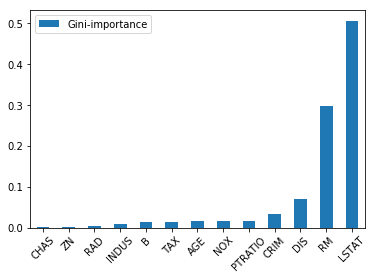

In [21]:
%matplotlib inline

feats = {} 
for feature, importance in zip(X_train.columns, rf.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

# Focus sur les Forêts Aléatoires en Classification

Nous utiliserons ici le dataset **iris**.

In [22]:
from sklearn.datasets import load_iris

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=["Classe"])
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

**Exercice Bilan** : Sur la base des données *iris*, appliquez une forêt aléatoire et utilisez le package **treeinterpreter** pour décomposer la prédiction pour certains points de données choisit manuellement.

En classification, les fonctions vues précédemment s'utilisent de la même manière mais les sorties sont différentes.. ;)

In [23]:
rf = RandomForestClassifier(random_state=1234)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1/3, random_state=1234)

rf.fit(X_train, y_train)
onerow = X_test.iloc[:1,]

prediction, priormean, contributions = ti.predict(rf, onerow)
print("Prediction", prediction)
print("Priormean", priormean)
print("Feature contributions:")
for c, feature in zip(contributions[0],iris.feature_names):
    print(feature, c)

Prediction [[0. 1. 0.]]
Priormean [[0.348 0.314 0.338]]
Feature contributions:
sepal length (cm) [ 0.          0.00353159 -0.00353159]
sepal width (cm) [ 0.        -0.0184375  0.0184375]
petal length (cm) [-0.12525     0.32571547 -0.20046547]
petal width (cm) [-0.22275     0.37519045 -0.15244045]


# Conclusion

Décomposer et rendre interprétable les prévisions des forêts aléatoires est finalement assez simple. Cela peut conduire à un niveau d'interprétabilité proche à celui des modèles linéaires. 